# LOAD EWAS Aging Data Brain with 55 cpgs from Eleonora


* Eleonora gave me 55 cpg sites to try modeling with in the brain tissue
* That is done here

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import json
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
plt.rcdefaults()

In [2]:
import csv
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')

In [3]:
import os
# Get
os.getcwd()
# Change
os.chdir('/Users/dcox/EWAS age premade')
os.getcwd()

'/Users/dcox/EWAS age premade'

### Function for loading data file and writing subset file by tissue, uses csv package for speed, not pandas

In [4]:
import math
import csv
import re

def findElements(lst1, lst2):
    '''
    returns a list of those elements in list1 that are at the position indices given in list2
    '''
    return [lst1[i] for i in lst2] 

def read_write_age_data_by_tissue(file_in, file_out, search_term, num_rows='all'):
    '''
    Built to operate on the EWAS aging dataset text file named 'age_methylation_v1.txt'
    
    Takes an input csv file, a file name to write to, and a search term which should equal a type of tissue 
    in the tissue row of the data (3rd row).
    
    Writes to a csv file the input data but containingg only the columns with tissue containing any where in it
    the search term
    
    params: 
        file_in (string) (file.csv) path to some existing csv file to read
        file_out (string) name of csv file to write 
        search_term (string) term to search for in tissue row
        
    returns:
        None
    '''
    with open(file_in, 'r') as file_in:

        csv_in = csv.reader(file_in,delimiter= '\t')

        header = next(csv_in)
        age = next(csv_in)
        tissue = next(csv_in)
       
        indices = [0]
        for i, element in enumerate(tissue):
            if re.search(search_term, element):
                indices.append(i)
            
        if len(indices) == 0:
            print('Tissue not found')
            return None 
        
        with open(file_out, 'w') as f_out:
            line_list = []
            csv_out = csv.writer(f_out)

            new_header =  findElements(header, indices)
            new_age =  findElements(age, indices)
            new_tissue =  findElements(tissue, indices)

            csv_out.writerow(new_header)
            #csv_out.writerow(new_age)
            #csv_out.writerow(new_tissue)

            count = 0
            if num_rows=='all':
                for line in csv_in:
                    save = findElements(line, indices)
                    csv_out.writerow(save)
                    count +=1
                    if count%10000 == 0:
                        print(f'finished line {count}')
            else:
                for line in csv_in:
                    if count >= num_rows:
                        break
                    else:
                        save = findElements(line, indices)
                        csv_out.writerow(save)
                        count +=1
                        if count%10000 == 0:
                            print(f'finished line {count}')
        return new_header, new_age, new_tissue

        print(f'\n{count} lines sent to file {file_out} with the tissue field containing {search_term}')

## Loading Data to dataframe

### Read data file and write new file with data from the selected tissue

In [5]:
%%time
# # Writing data to a file with the above function selecting out a certain tissue
new_header, new_age, new_tissue = read_write_age_data_by_tissue('./age_methylation_v1/age_methylation_v1.txt', './age_methylation_v1/brain_age_methylation_v1.txt', 'brain', num_rows='all')

finished line 10000
finished line 20000
finished line 30000
finished line 40000
finished line 50000
finished line 60000
finished line 70000
finished line 80000
finished line 90000
finished line 100000
finished line 110000
finished line 120000
finished line 130000
finished line 140000
finished line 150000
finished line 160000
finished line 170000
finished line 180000
finished line 190000
finished line 200000
finished line 210000
finished line 220000
finished line 230000
finished line 240000
finished line 250000
finished line 260000
finished line 270000
finished line 280000
finished line 290000
finished line 300000
finished line 310000
finished line 320000
finished line 330000
finished line 340000
finished line 350000
finished line 360000
finished line 370000
finished line 380000
finished line 390000
finished line 400000
finished line 410000
finished line 420000
finished line 430000
finished line 440000
finished line 450000
finished line 460000
finished line 470000
finished line 480000
C

### Read back in data in chunks and combine to new dataframe

In [6]:
%%time
# Reading data back in in chunks
import warnings
warnings.simplefilter(action='ignore', category=Warning)

chunksize = 10000
dfs = []
df_chunk = pd.read_csv('./age_methylation_v1/brain_age_methylation_v1.txt', header=0, chunksize=chunksize)
for chunk in df_chunk:
    dfs.append(chunk)

CPU times: user 1min, sys: 4 s, total: 1min 4s
Wall time: 1min 4s


In [7]:
%%time
# Combining chunks into 1 dataframe
df = pd.concat(dfs).set_index('sample_id') 

CPU times: user 3.43 s, sys: 6.61 s, total: 10 s
Wall time: 20 s


### Transpose dataframe so cpgs are columns, and add columns for age and tissue saved from the write operation

In [8]:
%%time
# transposing dataframe
df_t = df.transpose()

CPU times: user 4.08 ms, sys: 4.54 ms, total: 8.62 ms
Wall time: 22.4 ms


In [9]:
# Inserting columns for tissue and age and setting age dtype to float and then rounding to int
df_t.insert(0, 'age', new_age[1:])
df_t.insert(0, 'tissue', new_tissue[1:])
df_t.age = df_t.age.astype('float')
df_t.age = df_t.age.apply(np.rint)
df_t.age = df_t.age.astype('int64')

In [10]:
df_t.shape

(1437, 485514)

### Dealing with NAs

In [11]:
# %%time
# #looking at a histogram of the percent NAs for the columns
# num_nans_hist = 100 * df_t.isna().sum(axis=0)/df_t.shape[0]
# num_nans_hist.hist(bins=100)
# plt.xlabel('% NA')
# plt.ylabel('count')
# plt.ylim(0,50000)

In [12]:
#### Drop all columns with any NA

In [13]:
%%time
# Drop all columns with an NA
# df_processed = df_t.dropna(axis=1)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 3.1 µs


In [14]:
%%time
# df_processed.to_csv('df_EWAS_aging_brain_Na_droped')

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 2.86 µs


#### Or drop all columns with  NAs > 25% of values , then imput with mean of column

In [15]:
# remove columns with more than 25% NAs
df_processed_imp = df_t.dropna(thresh = 0.75*df_t.shape[0], axis=1)

In [16]:
df_processed_imp.shape

(1437, 390440)

In [17]:
%%time
# Impute all values with column mean
df_processed_imp = df_processed_imp.fillna(df_processed_imp.mean())

CPU times: user 4min 26s, sys: 1min 40s, total: 6min 7s
Wall time: 7min 44s


In [18]:
# %%time
# df_processed_imp.to_csv('df_EWAS_age_brain_Imputated_with_mean')

### Selecting out samples with ages over 20 years old

In [19]:
# Selecting out samples with age > 20
# df_processed_over20 = df_processed[df_processed.age >=20]
df_processed_imp_over20 = df_processed_imp[df_processed_imp.age >=20]

### Histogram of ages in data

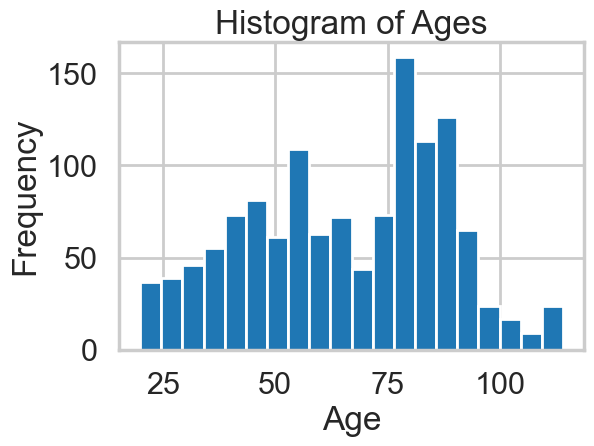

In [20]:
# Histogram of ages in data
plt.figure(figsize = (6,4))
df_processed_imp_over20.age.hist(bins=20)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Ages')
plt.show()

### Dividing data into working and saved parts

In [21]:
df_processed_imp_over20.shape

(1290, 390440)

In [22]:
# Splitting data into Working and Saved by random selection of rows

import random

num_samples = df_processed_imp_over20.shape[0]
num_for_saving = int(round(df_processed_imp_over20.shape[0]*.25))

np.random.seed(2021)

saved_index = np.random.choice(np.arange(num_samples), size=num_for_saving, replace=False)
keep_index = []
for num in range(num_samples):
    if num not in saved_index:
        keep_index.append(num)

df_p_saved = df_processed_imp_over20.iloc[saved_index, :]
df_p_working = df_processed_imp_over20.iloc[keep_index, :]

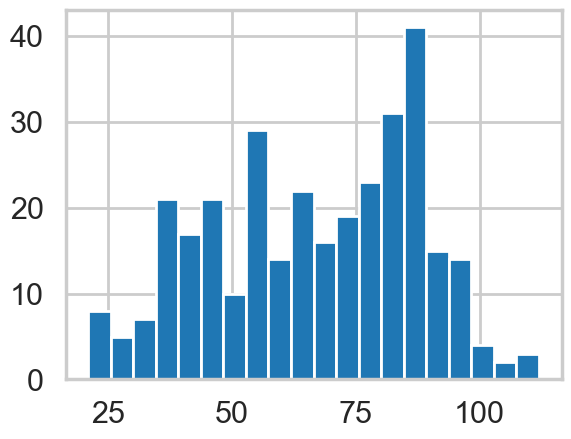

In [23]:
# Histogram of ages in saved data
df_p_saved.age.hist(bins=20)
plt.show()

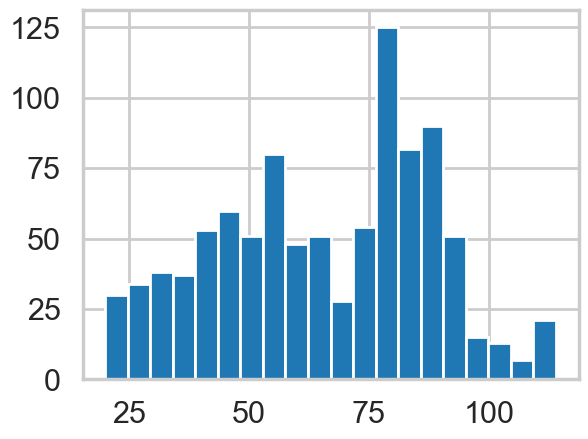

In [24]:
# Histogram of ages in working data
df_p_working.age.hist(bins=20)
plt.show()

In [25]:
df_p_working

sample_id,tissue,age,cg02494853,cg03706273,cg04023335,cg04964672,cg05213048,cg15295597,cg26520468,cg27539833,cg00008945,cg00011200,cg00011891,cg00016522,cg00016934,cg00018261,cg00021786,cg00026186,cg00072288,cg00072839,cg00074638,cg00112256,cg00114625,cg00114913,cg00116709,cg00139317,cg00140085,cg00142683,cg00192980,cg00200463,cg00206414,cg00240113,cg00241296,cg00241907,cg00243584,cg00264378,cg00265812,cg00266918,cg00360365,cg00373606,cg00374088,cg00378717,cg00378950,cg00380985,cg00381376,cg00388637,cg00391044,cg00399450,cg00408231,cg00412010,...,cg27553637,cg27575890,cg27585287,cg27592453,cg27598806,cg27601574,cg27611781,cg27612019,cg27614432,cg27634071,cg27648216,cg27656573,cg27657363,cg27657537,cg27660038,cg27662611,cg27665648,ch.22.16108507R,ch.22.16454022F,ch.22.40657F,ch.22.78028F,ch.22.17803970R,ch.22.107403R,ch.22.137888R,ch.22.22597277R,ch.22.217069R,ch.22.22928834R,ch.22.23746271F,ch.22.25752197R,ch.22.26167205F,ch.22.317144R,ch.22.26442001R,ch.22.28920330F,ch.22.30020508R,ch.22.427671F,ch.22.439136F,ch.22.467397R,ch.22.31817810F,ch.22.33863861F,ch.22.533187F,ch.22.569473R,ch.22.38010425R,ch.22.707968R,ch.22.740407F,ch.22.757911F,ch.22.43177094F,ch.22.46830341F,ch.22.1008279F,ch.22.47579720R,ch.22.48274842R
GSM2139432,brain - superior temporal gyrus,71,0.020,0.008,0.512,0.924000,0.718,0.018,0.951,0.947,0.000,0.012,0.018,0.21400,0.035000,0.004000,0.986,0.011,0.025,0.004,0.652,0.077,0.047,0.058000,0.025000,0.030,0.032,0.022,0.030,0.027,0.403,0.019,0.018,0.017,0.342,0.006,0.034,0.025,0.036000,0.026,0.329,0.017,0.896,0.023,0.007,0.724024,0.077000,0.030,0.906,0.086,...,0.013,0.116,0.110,0.842,0.964,0.938000,0.099,0.680,0.011,0.043,0.303,0.977000,0.948,0.220,0.094,0.022,0.751,0.073000,0.006,0.104000,0.047,0.243,0.033,0.208,0.210,0.385000,0.334,0.173,0.387,0.084,0.291000,0.331,0.479416,0.274,0.047,0.051000,0.121,0.131,0.219,0.091,0.238,0.132,0.010,0.053,0.038,0.117,0.157,0.016,0.148,0.082
GSM2139249,brain - superior temporal gyrus,76,0.013,0.011,0.150,0.868103,0.786,0.014,0.969,0.929,0.331,0.443,0.504,0.54500,0.126000,0.527000,0.945,0.486,0.423,0.055,0.669,0.531,0.531,0.463000,0.575000,0.525,0.406,0.475,0.499,0.553,0.339,0.472,0.213,0.348,0.439,0.433,0.513,0.055,0.256000,0.451,0.430,0.051,0.883,0.512,0.009,0.812000,0.370000,0.508,0.621,0.424,...,0.014,0.103,0.084,0.844,0.957,0.921000,0.080,0.604,0.012,0.032,0.293,0.977000,0.929,0.174,0.082,0.038,0.733,0.053000,0.009,0.083000,0.045,0.207,0.037,0.195,0.167,0.422000,0.303,0.070,0.361,0.087,0.252227,0.338,0.481000,0.266,0.038,0.049000,0.142,0.160,0.227,0.061,0.222,0.134,0.011,0.082,0.031,0.150,0.185,0.015,0.128,0.063
GSM2139398,brain - superior temporal gyrus,102,0.012,0.005,0.112,0.868103,0.753,0.017,0.964,0.922,0.350,0.466,0.481,0.55600,0.235000,0.474000,0.957,0.489,0.400,0.031,0.671,0.530,0.563,0.432000,0.611000,0.472,0.422,0.474,0.482,0.531,0.393,0.453,0.195,0.366,0.436,0.394,0.488,0.055,0.212000,0.444,0.435,0.052,0.889,0.461,0.007,0.820000,0.406000,0.508,0.562,0.423,...,0.012,0.165,0.089,0.769,0.960,0.928000,0.082,0.555,0.017,0.026,0.310,0.988000,0.865,0.160,0.081,0.021,0.688,0.039000,0.005,0.053000,0.085,0.207,0.035,0.164,0.144,0.386000,0.319,0.089,0.259,0.079,0.243000,0.246,0.392000,0.274,0.040,0.035000,0.086,0.176,0.185,0.065,0.172,0.088,0.017,0.056,0.039,0.107,0.112,0.010,0.098,0.080
GSM2139297,brain - superior temporal gyrus,108,0.012,0.002,0.109,0.868103,0.668,0.046,0.960,0.932,0.327,0.436,0.519,0.51500,0.061000,0.522000,0.973,0.484,0.433,0.102,0.668,0.540,0.538,0.503000,0.600000,0.475,0.407,0.498,0.541,0.544,0.436,0.469,0.189,0.289,0.431,0.415,0.509,0.052,0.277000,0.404,0.452,0.097,0.890,0.499,0.007,0.813000,0.396000,0.506,0.553,0.410,...,0.018,0.112,0.163,0.827,0.959,0.926000,0.120,0.767,0.017,0.029,0.405,0.978000,0.934,0.253,0.086,0.059,0.715,0.075623,0.004,0.065949,0.069,0.275,0.049,0.217,0.220,0.395891,0.415,0.167,0.395,0.183,0.252227,0.383,0.479416,0.356,0.048,0.037508,0.173,0.196,0.301,0.083,0.257,0.171,0.023,0.064,0.039,0.170,0.215,0.022,0.181,0.251
GSM106920

In [26]:
# %%time
# # Runnin XGboost on working dataset 50 times with 50 different train/test splits
# df_imp, rms_train, rms_test, r2_train, r2_test = repeat_XGBoost(df_p_working, 50, test_size=0.20)

In [27]:
#df_imp

In [28]:
# write 50 trails results to a file, so don't have to rerun the 50 XGboost trials with the whole dataset again
# df_imp.to_csv('df_importance_EWAS_age_brain_50_trials.csv')
df_imp = pd.read_csv('./brain/df_importance_EWAS_age_brain_50_trials.csv', index_col=0)

In [37]:
# Finding cpgs with on average the highest importance scores, see mean columnn in df below
df_imp_sorted = importances_sorted_by_mean(df_imp)

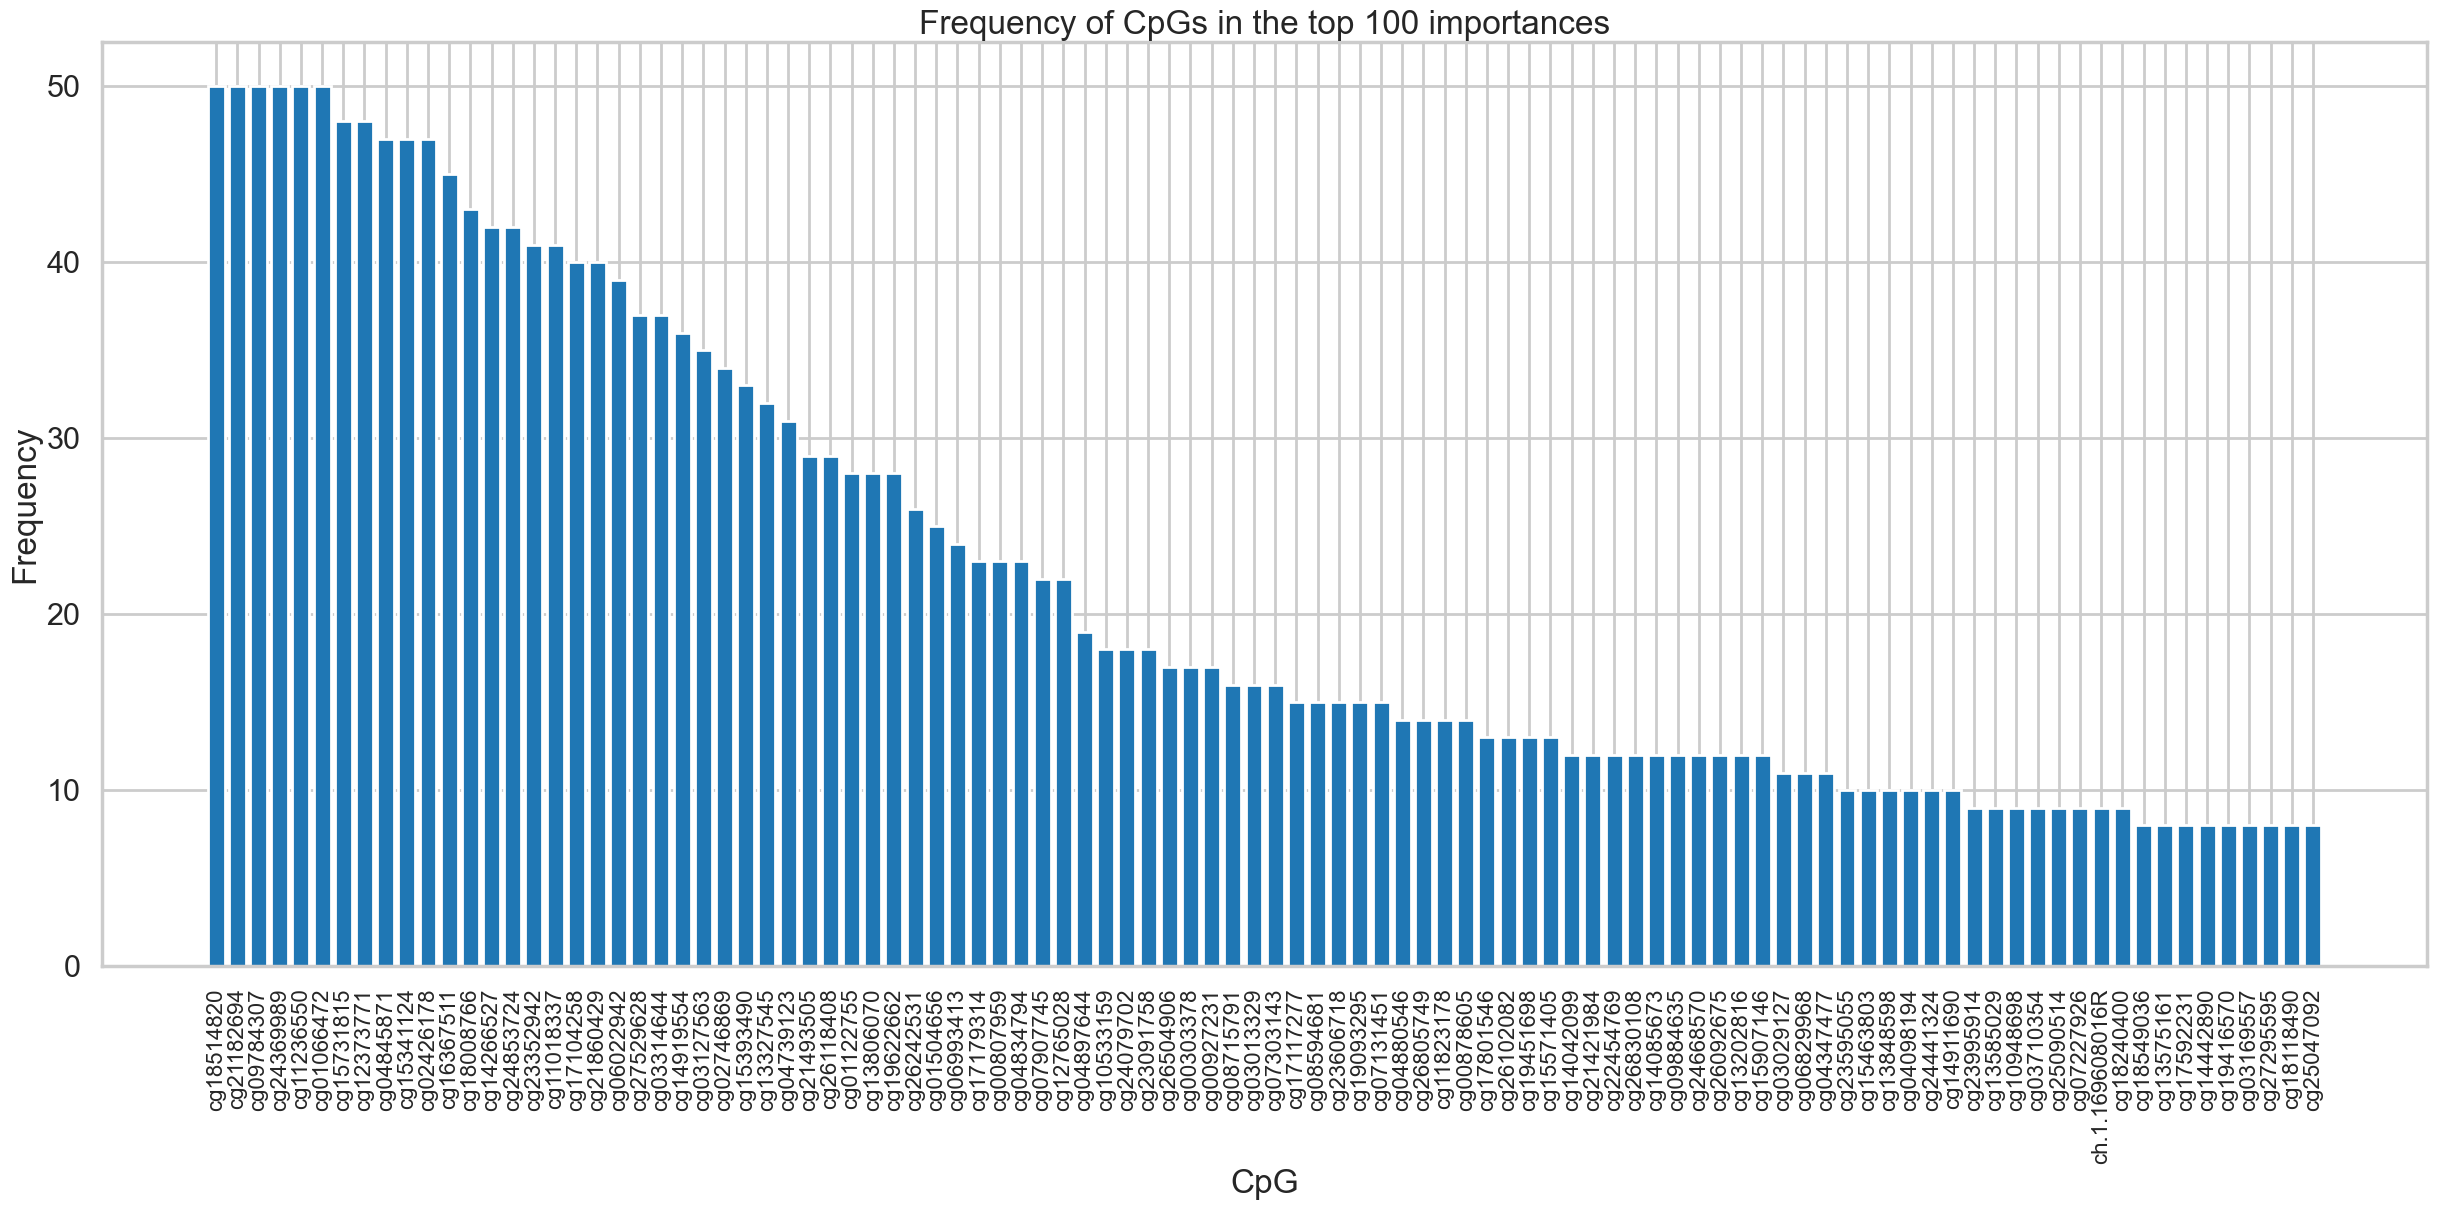

In [38]:
# This function makes a histogram of the frequency of cgs in the top 100 in the 50 trials above
inds, vs, h = histogram_of_top_CpGs_by_importance(df_imp, 100)

In [39]:
cpgs_XGboost_brain_ranked = h.index.values

In [40]:
# Savings Rankings, took 4hrs to get
# import pickle
# with open('cpgs_XGboost_brain_ranked', 'wb') as fp:
#     pickle.dump(cpgs_XGboost_brain_ranked, fp)

In [41]:
Top100_cpgs_XGboost_brain = h.index[:100].values

## Using 55 cpgs from Eleonora here

In [42]:
Top55 = ['cg01066472', 'cg18514820', 'cg21182694', 'cg11236550', 'cg24369989', 'cg15731815', 'cg04845871', 'cg15341124', 'cg16367511', 'cg18008766', 'cg11018337', 'cg23352942', 'cg17104258', 'cg06022942', 'cg02746869', 'cg15393490', 'cg13327545', 'cg04739123', 'cg26118408', 'cg13806070', 'cg19622662', 'cg00807959', 'cg04834794', 'cg17179314', 'cg12765028', 'cg07907745', 'cg04897644', 'cg10533159', 'cg24079702', 'cg23091758', 'cg00927231', 'cg00303378', 'cg08715791', 'cg07303143', 'cg23606718', 'cg17117277', 'cg11823178', 'cg17801546', 'cg19451698', 'cg26102082', 'cg15907146', 'cg26830108', 'cg22454769', 'cg24668570', 'cg04347477', 'cg06829968', 'cg23595055', 'cg04098194', 'cg15463803', 'cg24441324', 'cg14911690', 'cg07227926', 'cg25090514', 'cg23995914', 'cg03169557']

In [43]:
from sklearn.model_selection import train_test_split
X = df_p_working[Top55]
y = df_p_working.age
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 2021)

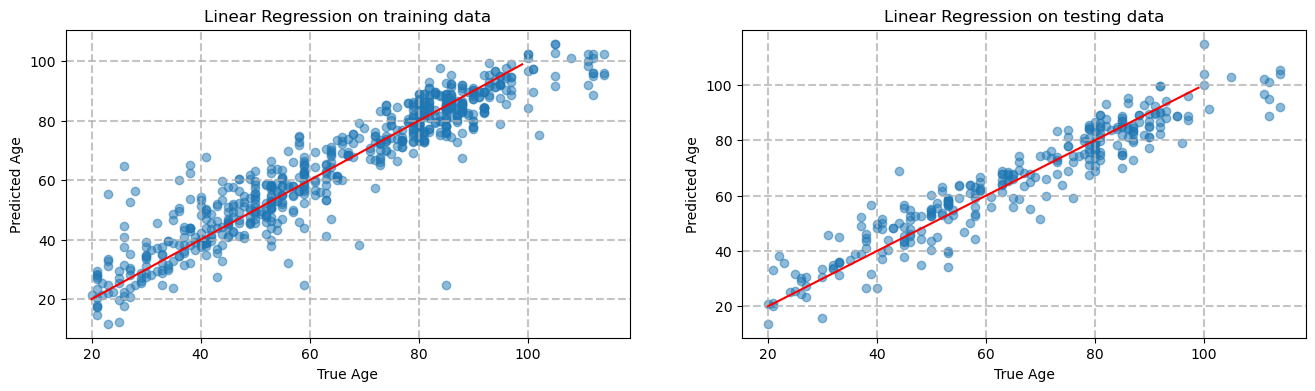

The rms on the training data is 7.772 years
The rms on the testing data is 7.102 years
The r^2 on the training data is 0.883
The r^2 on the testing data is 0.896
The MAe on the training data is 5.429 years
The MAE on the testing data is 5.530


In [44]:
plt.rcdefaults()
mod_100, rms_train, rms_test, r2_train, r2_test = linear_regress(X_train, y_train, X_test, y_test, plot=True)

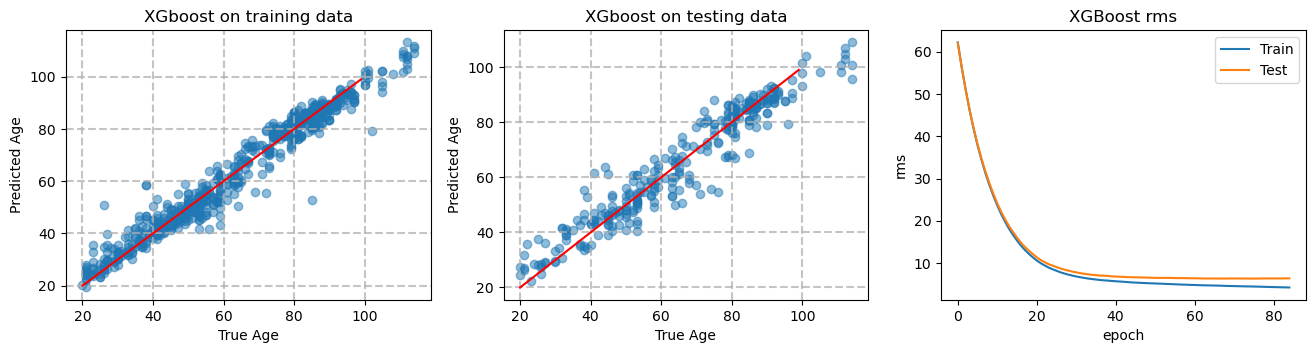

The number of training epochs was 85
The rms on the training data is 4.480 years
The rms on the testing data is 6.356 years
The r^2 on the training data is 0.961
The r^2 on the testing data is 0.917
The MAe on the training data is 3.136 years
The MAE on the testing data is 4.762


In [45]:
XG_100, rms_train, rms_test, r2_train, r2_test, feature_importances_ = xgboost_regress(X_train, y_train, X_test, y_test, early_stopping_rounds=10, plot=True)

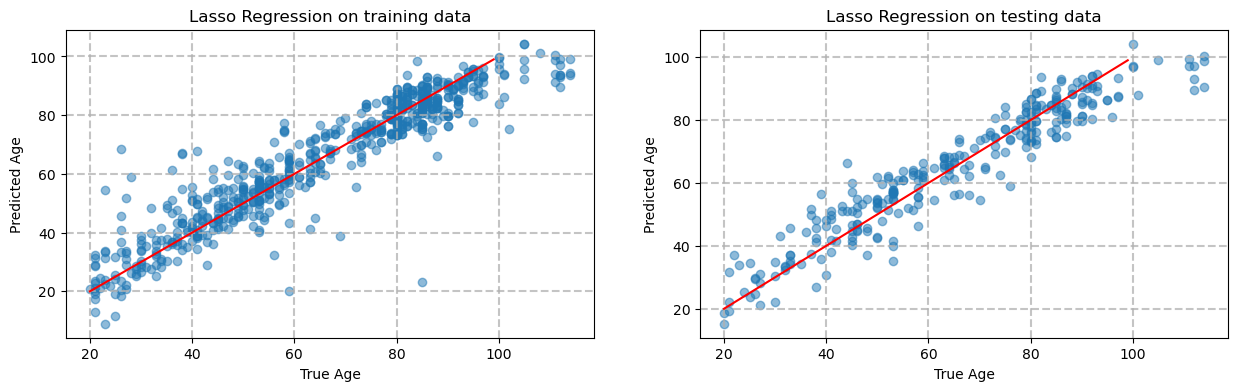

The rms on the training data is 7.979 years
The rms on the testing data is 6.927 years
The r^2 on the training data is 0.876
The r^2 on the testing data is 0.901
The MAe on the training data is 5.416 years
The MAE on the testing data is 5.417 years


In [46]:
mod_lasso_100, rms_train, rms_test, r2_train, r2_test = lassoCV_regress(X_train, y_train, X_test, y_test, plot=True, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5)

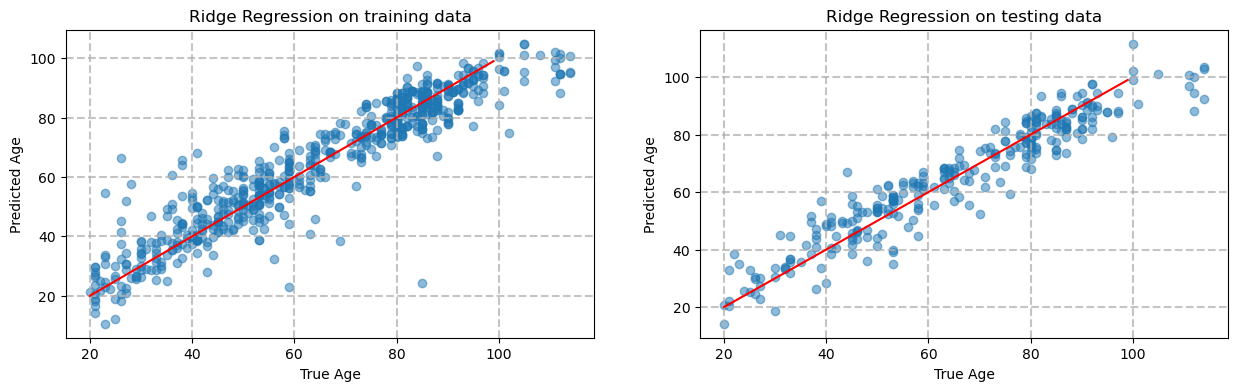

The rms on the training data is 7.809 years
The rms on the testing data is 6.966 years
The r^2 on the training data is 0.881
The r^2 on the testing data is 0.900
The MAe on the training data is 5.381 years
The MAE on the testing data is 5.440 years


In [47]:
mod_ridge_100, rms_train, rms_test, r2_train, r2_test = ridgeCV_regress(X_train, y_train, X_test, y_test, plot=True, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5)

In [48]:
# Save models
import pickle

with open('mod_55_brain', 'wb') as fp:
    pickle.dump(mod_100, fp)
    
with open('XG_55_brain', 'wb') as fp:
    pickle.dump(XG_100, fp)
    
with open('mod_lasso_55_brain', 'wb') as fp:
    pickle.dump(mod_lasso_100, fp)
    
with open('mod_ridge_55_brain', 'wb') as fp:
    pickle.dump(mod_ridge_100, fp)

### Looking at model on saved data

In [49]:
plt.rcdefaults()
X_saved = df_p_saved[Top55]
y_saved = df_p_saved.age

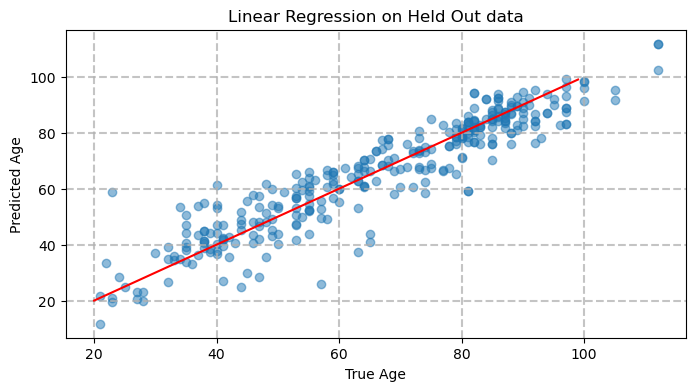

The MSE on the saved data is 59.092 years
The rms on the saved data is 7.687 years
The r^2 on the saved data is 0.865
The mae on the saved data is 5.591 years
The correlation on the held out data true-predicted is 0.931


In [50]:
preds, MSE, rms, r2, MAE, r_corr = test_model_on_heldout_data(X_saved, y_saved, mod_100, mtype='Linear Regression', figsize=(8,4), xlim=None)

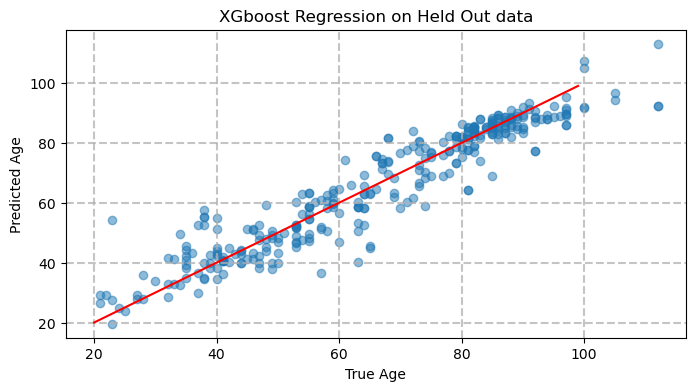

The MSE on the saved data is 45.755 years
The rms on the saved data is 6.764 years
The r^2 on the saved data is 0.896
The mae on the saved data is 4.893 years
The correlation on the held out data true-predicted is 0.947


In [51]:
preds, MSE, rms, r2, MAE, r_corr = test_model_on_heldout_data(X_saved, y_saved, XG_100, mtype='XGboost Regression', figsize=(8,4), xlim=None)

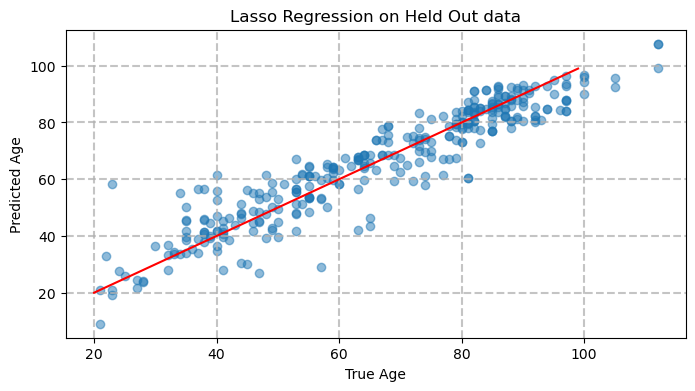

The MSE on the saved data is 54.517 years
The rms on the saved data is 7.384 years
The r^2 on the saved data is 0.876
The mae on the saved data is 5.431 years
The correlation on the held out data true-predicted is 0.936


In [52]:
preds, MSE, rms, r2, MAE, r_corr = test_model_on_heldout_data(X_saved, y_saved, mod_lasso_100, mtype='Lasso Regression', figsize=(8,4), xlim=None)

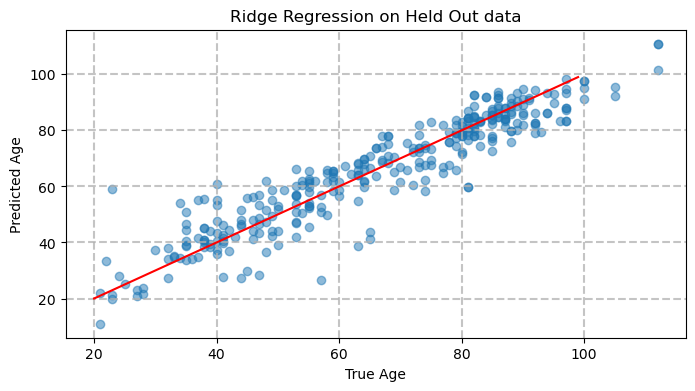

The MSE on the saved data is 57.241 years
The rms on the saved data is 7.566 years
The r^2 on the saved data is 0.869
The mae on the saved data is 5.542 years
The correlation on the held out data true-predicted is 0.933


In [53]:
preds, MSE, rms, r2, MAE, r_corr = test_model_on_heldout_data(X_saved, y_saved, mod_ridge_100, mtype='Ridge Regression', figsize=(8,4), xlim=None)

## FUNCTIONS

In [31]:
def test_model_on_heldout_data(X_saved, y_saved, model, mtype='Linear Regression', figsize=(8,4), xlim=None):
    
    # Using  model to make predictions on saved data
    preds_on_saved = model.predict(X_saved)
    MSE_test = mean_squared_error(y_saved, preds_on_saved)
    rms_test = (mean_squared_error(y_saved, preds_on_saved))**0.5
    r2_test = r2_score(y_saved, preds_on_saved)
    MAE_test = mean_absolute_error(y_saved, preds_on_saved)
    r_test_corr = np.corrcoef(y_saved, preds_on_saved)[0,1] # preds_on_saved
    
    # Plotting results
    model_type = mtype

    fig, ax = plt.subplots(1,1, figsize=figsize)
    ax.scatter(y_saved, preds_on_saved, alpha=0.5)
    ax.plot(range(20,100), range(20,100), c='red')
    ax.set_xlabel('True Age')
    if xlim !=None:
        ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylabel('Predicted Age')
    ax.grid(True, lw=1.5, ls='--', alpha=0.75)
    ax.set_title(f'{model_type} on Held Out data')
    plt.show()

    # print metric
    print(f'The MSE on the saved data is {MSE_test:.3f} years')
    print(f'The rms on the saved data is {rms_test:.3f} years')
    print(f'The r^2 on the saved data is {r2_test:.3f}')
    print(f'The mae on the saved data is {MAE_test:.3f} years')
    print(f'The correlation on the held out data true-predicted is {r_test_corr:.3f}')
    
    return preds_on_saved, MSE_test, rms_test, r2_test, MAE_test, r_test_corr

In [32]:
# Run Linear Regression model and plot and print results
from sklearn.linear_model import LinearRegression
def linear_regress(X_train, y_train, X_test, y_test, plot=True):
    
    #Build fit model
    mod = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs='None')
    mod.fit(X_train, y_train)
    
    # Make predictions and evaluate
    preds_train = mod.predict(X_train)
    preds_test = mod.predict(X_test)
    rms_train = (mean_squared_error(y_train, preds_train))**0.5
    rms_test = (mean_squared_error(y_test, preds_test))**0.5
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)
    mae_train = mean_absolute_error(y_train, preds_train)
    mae_test = mean_absolute_error(y_test, preds_test)
    
    # Plot progress over epochs and final true vs predicted age
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(16,4))
        ax[0].scatter(y_train, preds_train, alpha=0.5)
        ax[0].plot(range(20,100), range(20,100), c='red')
        ax[0].set_xlabel('True Age')
        ax[0].set_ylabel('Predicted Age')
        ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[0].set_title('Linear Regression on training data')

        ax[1].scatter(y_test, preds_test, alpha=0.5)
        ax[1].plot(range(20,100), range(20,100), c='red')
        ax[1].set_xlabel('True Age')
        ax[1].set_ylabel('Predicted Age')
        ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[1].set_title('Linear Regression on testing data')
        plt.show()
    
    # print metric
    print(f'The rms on the training data is {rms_train:.3f} years')
    print(f'The rms on the testing data is {rms_test:.3f} years')
    print(f'The r^2 on the training data is {r2_train:.3f}')
    print(f'The r^2 on the testing data is {r2_test:.3f}')
    print(f'The MAe on the training data is {mae_train:.3f} years')
    print(f'The MAE on the testing data is {mae_test:.3f}')
    
    
    return mod, rms_train, rms_test, r2_train, r2_test

In [33]:
# Function for running XGboost regression and print results
from xgboost import XGBRegressor
def xgboost_regress(X_train, y_train, X_test, y_test, early_stopping_rounds=None, plot=True):
    
    #Build fit model
    XG = XGBRegressor(objective='reg:squarederror',
                    n_estimators=200,
                    min_child_weight=1,
                    max_depth=3,
                    subsample=0.7,
                    colsample_bytree=0.5,
                    learning_rate=0.1)
    
    eval_set = [(X_train, y_train),(X_test, y_test)]
    XG.fit(X_train, y_train, eval_metric="rmse", early_stopping_rounds = early_stopping_rounds, eval_set=eval_set, verbose=False)
    
    
    # Make predictions and evaluate
    preds_train = XG.predict(X_train)
    preds_test = XG.predict(X_test)
    rms_train = (mean_squared_error(y_train, preds_train))**0.5
    rms_test = (mean_squared_error(y_test, preds_test))**0.5
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)
    mae_train = mean_absolute_error(y_train, preds_train)
    mae_test = mean_absolute_error(y_test, preds_test)
    results = XG.evals_result()
    epochs = len(results['validation_0']['rmse'])
    
    # Plot progress over epochs and final true vs predicted age
    if plot:
        fig, ax = plt.subplots(1,3, figsize=(16,3.5))
        ax[0].scatter(y_train, preds_train, alpha=0.5)
        ax[0].plot(range(20,100), range(20,100), c='red')
        ax[0].set_xlabel('True Age')
        ax[0].set_ylabel('Predicted Age')
        ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[0].set_title('XGboost on training data')

        ax[1].scatter(y_test, preds_test, alpha=0.5)
        ax[1].plot(range(20,100), range(20,100), c='red')
        ax[1].set_xlabel('True Age')
        ax[1].set_ylabel('Predicted Age')
        ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[1].set_title('XGboost on testing data')

        x_axis = range(0, epochs)
        ax[2].plot(x_axis, results['validation_0']['rmse'], label='Train')
        ax[2].plot(x_axis, results['validation_1']['rmse'], label='Test')
        ax[2].legend()
        ax[2].set_ylabel('rms')
        ax[2].set_xlabel('epoch')
        ax[2].set_title('XGBoost rms')
        plt.show()
    
    # print metric
    print(f'The number of training epochs was {epochs}')
    print(f'The rms on the training data is {rms_train:.3f} years')
    print(f'The rms on the testing data is {rms_test:.3f} years')
    print(f'The r^2 on the training data is {r2_train:.3f}')
    print(f'The r^2 on the testing data is {r2_test:.3f}')
    print(f'The MAe on the training data is {mae_train:.3f} years')
    print(f'The MAE on the testing data is {mae_test:.3f}')
    
    
    return XG, rms_train, rms_test, r2_train, r2_test, XG.feature_importances_

In [34]:
# Function for running a ridge Regression model with CV on alpha
# and plot and print results
from sklearn.linear_model import RidgeCV
def ridgeCV_regress(X_train, y_train, X_test, y_test, plot=True, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5):

    #Build fit model
    mod = mod = RidgeCV(alphas=alphas,cv=cv)
    mod.fit(X_train, y_train)
    
    # Make predictions and evaluate
    preds_train = mod.predict(X_train)
    preds_test = mod.predict(X_test)
    rms_train = (mean_squared_error(y_train, preds_train))**0.5
    rms_test = (mean_squared_error(y_test, preds_test))**0.5
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)
    mae_train = mean_absolute_error(y_train, preds_train)
    mae_test = mean_absolute_error(y_test, preds_test)
    
    # Plot final true vs predicted age
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(15,4))
        ax[0].scatter(y_train, preds_train, alpha=0.5)
        ax[0].plot(range(20,100), range(20,100), c='red')
        ax[0].set_xlabel('True Age')
        ax[0].set_ylabel('Predicted Age')
        ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[0].set_title('Ridge Regression on training data')

        ax[1].scatter(y_test, preds_test, alpha=0.5)
        ax[1].plot(range(20,100), range(20,100), c='red')
        ax[1].set_xlabel('True Age')
        ax[1].set_ylabel('Predicted Age')
        ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[1].set_title('Ridge Regression on testing data')
        plt.show()
    
    # print metric
    print(f'The rms on the training data is {rms_train:.3f} years')
    print(f'The rms on the testing data is {rms_test:.3f} years')
    print(f'The r^2 on the training data is {r2_train:.3f}')
    print(f'The r^2 on the testing data is {r2_test:.3f}')
    print(f'The MAe on the training data is {mae_train:.3f} years')
    print(f'The MAE on the testing data is {mae_test:.3f} years')
    
    return mod, rms_train, rms_test, r2_train, r2_test

In [35]:
# Function for running a lasso Regression model with CV on alpha
# and plot and print results
from sklearn.linear_model import LassoCV
def lassoCV_regress(X_train, y_train, X_test, y_test, plot=True, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5):

    #Build fit model
    mod = mod = LassoCV(alphas=alphas,cv=cv)
    mod.fit(X_train, y_train)
    
    # Make predictions and evaluate
    preds_train = mod.predict(X_train)
    preds_test = mod.predict(X_test)
    rms_train = (mean_squared_error(y_train, preds_train))**0.5
    rms_test = (mean_squared_error(y_test, preds_test))**0.5
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)
    mae_train = mean_absolute_error(y_train, preds_train)
    mae_test = mean_absolute_error(y_test, preds_test)
    
    # Plot final true vs predicted age
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(15,4))
        ax[0].scatter(y_train, preds_train, alpha=0.5)
        ax[0].plot(range(20,100), range(20,100), c='red')
        ax[0].set_xlabel('True Age')
        ax[0].set_ylabel('Predicted Age')
        ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[0].set_title('Lasso Regression on training data')

        ax[1].scatter(y_test, preds_test, alpha=0.5)
        ax[1].plot(range(20,100), range(20,100), c='red')
        ax[1].set_xlabel('True Age')
        ax[1].set_ylabel('Predicted Age')
        ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[1].set_title('Lasso Regression on testing data')
        plt.show()
    
    # print metric
    print(f'The rms on the training data is {rms_train:.3f} years')
    print(f'The rms on the testing data is {rms_test:.3f} years')
    print(f'The r^2 on the training data is {r2_train:.3f}')
    print(f'The r^2 on the testing data is {r2_test:.3f}')
    print(f'The MAe on the training data is {mae_train:.3f} years')
    print(f'The MAE on the testing data is {mae_test:.3f} years')
    
    return mod, rms_train, rms_test, r2_train, r2_test

In [36]:
# repeat_XGBoost numtrials times using a different split each time 
# returns importance scores for each run in a df 
def repeat_XGBoost(df_processed, numtrials, early_stopping_rounds = 10, test_size=0.20):
    X = df_processed.iloc[:,5:]
    y = df_processed.age
    importances = []
    rms_train = []
    rms_test = []
    r2_train = []
    r2_test = []
    for i in range(numtrials): 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        
        XG = XGBRegressor(objective='reg:squarederror',
                    n_estimators=200,
                    min_child_weight=1,
                    max_depth=3,
                    subsample=0.7,
                    colsample_bytree=0.5,
                    learning_rate=0.1)
    
        eval_set = [(X_train, y_train),(X_test, y_test)]
        XG.fit(X_train, y_train, eval_metric="rmse", early_stopping_rounds = early_stopping_rounds, eval_set=eval_set, verbose=False)
        
        preds_train = XG.predict(X_train)
        preds_test = XG.predict(X_test)
        rms_train.append((mean_squared_error(y_train, preds_train))**0.5)
        rms_test.append((mean_squared_error(y_test, preds_test))**0.5)
        r2_train.append(r2_score(y_train, preds_train))
        r2_test.append(r2_score(y_test, preds_test))
        print(i+1, f'r^2 test = {r2_score(y_test, preds_test)}')
        importances.append(XG.feature_importances_)
    df_imp = pd.DataFrame(importances, columns = df_processed.columns[5:])
    df_imp = df_imp.transpose()
    cols = []
    for i in range(1,numtrials+1):
        cols.append('trial_'+str(i))
    df_imp.columns = cols
    df_imp['Mean'] = df_imp.mean(axis=1)
    df_imp['Std'] = df_imp.std(axis=1)
    return df_imp, rms_train, rms_test, r2_train, r2_test

# Takes df of importance scores produced by repeat_XGBoost and sorts by mean imp score
def importances_sorted_by_mean(df_imp):
    df_imp_sorted = df_imp.sort_values('Mean', ascending=False)
    return df_imp_sorted

# Makes a histogram of the frequecy of cgs in the top (top_num) importance scores
def histogram_of_top_CpGs_by_importance(df_imp, top_num=20):
    vs = []
    inds = []
    for col in df_imp.columns[:-2]:
        c = df_imp[col].sort_values(ascending=False)
        vs.append(c[:top_num])
        inds  = inds + list(c.index[:top_num])
    h = pd.Series(inds).value_counts()
    # Plotting the first 100 importance scores
    plt.figure(figsize = (30, 12))
    plt.bar(h.index[:100],h[:100])
    plt.title('Frequency of CpGs in the top 100 importances')
    plt.ylabel('Frequency')
    plt.xlabel('CpG')
    plt.xticks(fontsize = 16, rotation=90)
    plt.show()
    return inds, vs, h